## Part1. Compare GNNs 

In [1]:
import os
import pandas as pd
import numpy as np
from hgnn.load_data import load_data
from hgnn.features import Graph_smiles
from hgnn.trainers import train_gnn
from hgnn.model import HGNNPredictor
from contrast_gnns.GraphVAE import *
from contrast_gnns.GraphTransformers import *
from contrast_gnns.GraphSAGE import *
from contrast_gnns.WLN import *
from dgllife.model.model_zoo import AttentiveFPPredictor, PAGTNPredictor

pwd = os.path.abspath('.')+'/'
print(pwd)

/home/hy/Documents/Project/bitterants/


#### 1.1 Public Dataset Information

In [2]:
"""
datasets are originally from:
https://github.com/masashitsubaki/molecularGNN_smiles/tree/master
https://github.com/shenwanxiang/ChemBench/tree/6master
"""

regress_datasets = ['delaney', 'PDBbind', 'FreeSolv', 'Lipop']
classify_datasets = ['BACE', 'N6512', 'ClinTox2', 'BBBP2']
regress_datasets_paths = [pwd+'dataset/public_dataset/regression/'+dataset+'.csv' for dataset in regress_datasets]
classify_datasets_paths = [pwd+'dataset/public_dataset/classification/'+dataset+'.csv' for dataset in classify_datasets]


print('--------regress dataset---------')
print('dataset', 'number', 'min', 'max')
for i,data_path in enumerate(regress_datasets_paths):
    if os.path.exists(data_path):
        df = pd.read_csv(data_path, header=0, sep='\t')
        print(regress_datasets[i], len(df), df['Label'].min(), df['Label'].max())

print('--------classify dataset---------')
print('dataset', 'number', 'number of 0', 'number of 1')
for i,data_path in enumerate(classify_datasets_paths):
    if os.path.exists(data_path):
        df = pd.read_csv(data_path, header=0, sep='\t')
        print(classify_datasets[i], len(df), df['Label'].value_counts().to_list()[0], df['Label'].value_counts().to_list()[1])


--------regress dataset---------
dataset number min max
delaney 1128 -11.6 1.58
PDBbind 3040 -2.438032426 2.055143546
FreeSolv 642 -25.47 3.43
Lipop 4200 -1.5 4.5
--------classify dataset---------
dataset number number of 0 number of 1
BACE 1513 822 691
N6512 6506 3497 3009
ClinTox2 1478 1366 112
BBBP2 2039 1560 479


#### 1.2 Compare GNNs 

In [3]:
combinations = []
for  i in [True,False]:
    for  j in [True,False]:
        for  k in [True,False]:
            for  l in [True,False]:
                combinations.append([i,j,k,l])
n_node_feats = 74
n_edge_feats = 12 
repeats = 5

##### 1.2.1 classify

In [4]:
classify_results = []
n_tasks = 2

for repeat in range(repeats):
    print("repeat {}".format(repeat))
    for dataset_idx,data_path in enumerate(classify_datasets_paths):
        print("start train: ", classify_datasets[dataset_idx])
        df = pd.read_csv(data_path, header=0, sep='\t')
        tuple_ls = list(zip(list(df['Smiles']), list(df['Label'])))
        batchsize = int(len(tuple_ls)/16)
        kfolds = load_data(tuple_ls, featurizer=Graph_smiles, if_all=False, Stratify=True, if_torch=True, batchsize=batchsize, graph=True, drop_last=True)
        # 16 modular designed models
        for combination in combinations:
            model = HGNNPredictor(
                                node_gat = combination[0], 
                                edge_gat = combination[1], 
                                weave = combination[2], 
                                mpnn = combination[3], 
                                n_node_feats=n_node_feats, n_edge_feats=n_edge_feats, num_layers=2, n_heads=5, n_hidden_feats=100, activation=F.relu, attn_activation=nn.LeakyReLU(negative_slope=0.2), attn_dropout=0, feat_dropout=0, xavier_normal=False, n_tasks=n_tasks,
                                )
            rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
            classify_results.append(rst)
        # other 5 models
        model = WLNPredictor(node_in_feats=n_node_feats, edge_in_feats=n_edge_feats, node_out_feats=100, n_layers=2, project_in_feats=True, set_comparison=True, n_tasks=n_tasks)
        rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        classify_results.append(rst)

        model = PAGTNPredictor(node_in_feats=n_node_feats, node_hid_feats=100, node_out_feats=100, edge_feats=n_edge_feats, depth=2, nheads=5, dropout=0.1, activation=nn.LeakyReLU(0.2), n_tasks=n_tasks, mode='sum') 
        rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        classify_results.append(rst)

        model = AttentiveFPPredictor(node_feat_size=n_node_feats,edge_feat_size=n_edge_feats,num_layers=2,num_timesteps=2,graph_feat_size=100,n_tasks=n_tasks,dropout=0.) 
        rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        classify_results.append(rst)

        model = GraphTransformerPredictor(in_dim=n_node_feats, hidden_dim=100, out_dim=100, n_tasks=n_tasks, num_layers=2, num_heads=5)
        rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=False, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        classify_results.append(rst)
        
        model = GraphSAGEPredictor(in_feats=n_node_feats, hidden_feats=[100,100], activation=None, dropout=None, aggregator_type=None, n_tasks=n_tasks)
        rst = train_gnn.train_bi_classify_kfolds(model, kfolds=kfolds, edge=False, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        classify_results.append(rst)
np.savetxt(pwd+"/results/compare_gnn/classify.txt", np.array(classify_results))

repeat 0
start train:  BACE


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  N6512


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  ClinTox2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  BBBP2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 1
start train:  BACE


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  N6512


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  ClinTox2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  BBBP2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 2
start train:  BACE


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  N6512


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  ClinTox2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  BBBP2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 3
start train:  BACE


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  N6512


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  ClinTox2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  BBBP2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 4
start train:  BACE


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  N6512


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  ClinTox2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  BBBP2


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


##### 1.2.2 regress

In [5]:
regress_results = []
n_tasks = 1

for repeat in range(repeats):
    print("repeat {}".format(repeat))
    for dataset_idx,data_path in enumerate(regress_datasets_paths):
        print("start train: ", regress_datasets[dataset_idx])
        df = pd.read_csv(data_path, header=0, sep='\t')
        tuple_ls = list(zip(list(df['Smiles']), list(df['Label'])))
        batchsize = int(len(tuple_ls)/16)
        kfolds = load_data(tuple_ls, featurizer=Graph_smiles, if_all=False, Stratify=False, if_torch=True, batchsize=batchsize, graph=True, drop_last=False)

        # 16 modular designed models
        for combination in combinations:
            model = HGNNPredictor(
                                node_gat = combination[0], 
                                edge_gat = combination[1], 
                                weave = combination[2], 
                                mpnn = combination[3], 
                                n_node_feats=n_node_feats, n_edge_feats=n_edge_feats, num_layers=2, n_heads=5, n_hidden_feats=100, activation=F.relu, attn_activation=nn.LeakyReLU(negative_slope=0.2), attn_dropout=0, feat_dropout=0, xavier_normal=False, n_tasks=n_tasks,
                                )
            rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
            regress_results.append(rst)
        # other 5 models
        model = WLNPredictor(node_in_feats=n_node_feats, edge_in_feats=n_edge_feats, node_out_feats=100, n_layers=2, project_in_feats=True, set_comparison=True, n_tasks=n_tasks)
        rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        regress_results.append(rst)

        model = PAGTNPredictor(node_in_feats=n_node_feats, node_hid_feats=100, node_out_feats=100, edge_feats=n_edge_feats, depth=2, nheads=5, dropout=0.1, activation=nn.LeakyReLU(0.2), n_tasks=n_tasks, mode='sum') 
        rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        regress_results.append(rst)

        model = AttentiveFPPredictor(node_feat_size=n_node_feats,edge_feat_size=n_edge_feats,num_layers=2,num_timesteps=2,graph_feat_size=100,n_tasks=n_tasks,dropout=0.) 
        rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=True, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        regress_results.append(rst)

        model = GraphTransformerPredictor(in_dim=n_node_feats, hidden_dim=100, out_dim=100, n_tasks=n_tasks, num_layers=2, num_heads=5)
        rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=False, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        regress_results.append(rst)
        
        model = GraphSAGEPredictor(in_feats=n_node_feats, hidden_feats=[100,100], activation=None, dropout=None, aggregator_type=None, n_tasks=n_tasks)
        rst = train_gnn.train_regress_kfolds(model, kfolds=kfolds, edge=False, max_epochs=500, patience=7, save_folder=pwd+'/pretrained/',save_name='gnn.pth')
        regress_results.append(rst)
np.savetxt(pwd+"/results/compare_gnn/regress.txt", np.array(regress_results))

repeat 0
start train:  delaney


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  PDBbind


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  FreeSolv


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  Lipop


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 1
start train:  delaney


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  PDBbind


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  FreeSolv


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  Lipop


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 2
start train:  delaney


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  PDBbind


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  FreeSolv


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  Lipop


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 3
start train:  delaney


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  PDBbind


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  FreeSolv


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  Lipop


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


repeat 4
start train:  delaney


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  PDBbind


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  FreeSolv


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


start train:  Lipop


/home/hy/Softwares/Program/miniconda3/envs/ml/lib/python3.8/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


#### 1.3 Plot

In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
regress_labels = ["R2", "MAE", "RMSE"]
classify_labels = ["ACC", "AP", "F1", "MCC","AUC"]
models = [f"M{i}" for i in range(1,17)] + ["C1", "C2","C3", "C4", "C5"]

regress_results= np.array(regress_results).reshape(5,4,21,4).mean(0)
classify_results = np.array(classify_results).reshape(5,4,21,12).mean(0)
regress_plot_data = np.concatenate((regress_results[:,:,:2], np.expand_dims(regress_results[:,:,-1],-1)), -1)
classify_plot_data = classify_results[:,:,-5:]
print(regress_plot_data.shape)
print(classify_plot_data.shape)

regress_datasets = ['delaney', 'PDBbind', 'FreeSolv', 'Lipop']
classify_datasets = ['BACE', 'N6512', 'ClinTox2', 'BBBP2']


(4, 21, 3)
(4, 21, 5)


##### plot regress

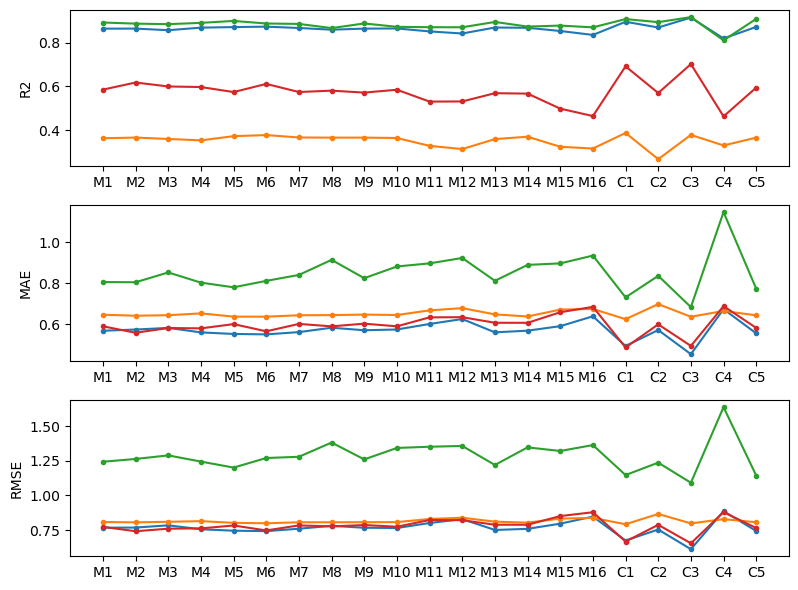

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6),)
axs = axs.ravel()
for i in range(len(regress_labels)):
    data = regress_plot_data[:,:,i]
    for j,y in enumerate(data):
        axs[i].plot(models, y, label=regress_datasets[j],marker=".")
    axs[i].set(ylabel=regress_labels[i])
plt.tight_layout()
plt.savefig(pwd+"/results/compare_gnn/regress.png",dpi=200)
plt.show()

##### plot classify

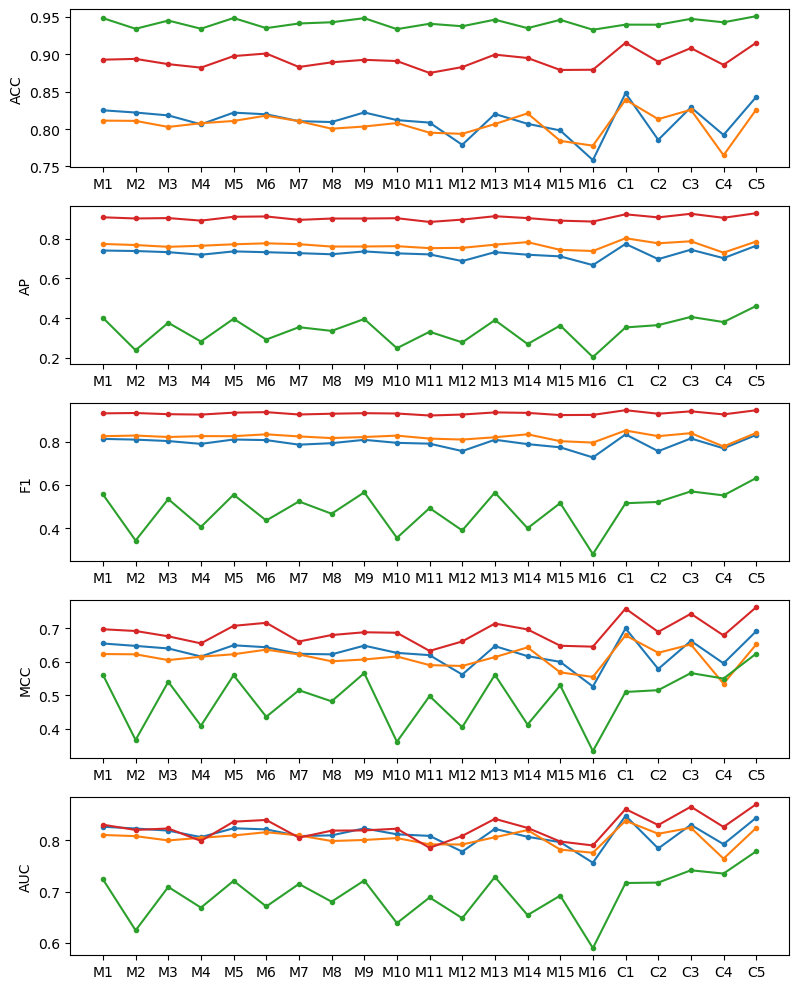

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(8, 10),)
axs = axs.ravel()
for i in range(len(classify_labels)):
    data = classify_plot_data[:,:,i]
    for j,y in enumerate(data):
        axs[i].plot(models, y, label=classify_datasets[j],marker=".")
    axs[i].set(ylabel=classify_labels[i])
plt.tight_layout()
plt.savefig(pwd+"/results/compare_gnn/classify.png",dpi=200)


##### score

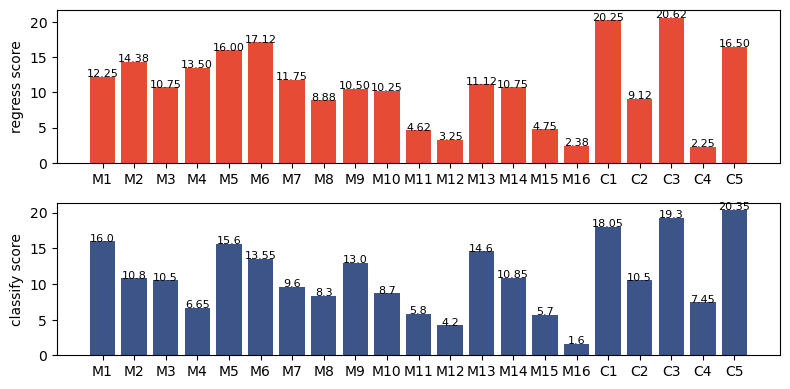

In [19]:
def rank_list(input_list, reverse=False):
    sorted_list = sorted(input_list, reverse=reverse)
    rank_dict = {sorted_list[i]: i + 1 for i in range(len(sorted_list))}
    rank_list = [rank_dict[i] for i in input_list]
    return rank_list


model_regress_score = []
for dataset in regress_plot_data:
    for metric in range(1,3):
        if metric ==0 :
            model_regress_score.append(rank_list(dataset[:,metric], reverse=False))
        else:
            model_regress_score.append(rank_list(dataset[:,metric], reverse=True))
model_regress_score=np.array(model_regress_score).mean(0)

model_classify_score = []
for dataset in classify_plot_data:
    for metric in range(5):
        model_classify_score.append(rank_list(dataset[:,metric]))
model_classify_score=np.array(model_classify_score).mean(0)

fig, axs = plt.subplots(2, 1, figsize=(8, 4),)
axs = axs.ravel()
axs[0].bar(models, model_regress_score, color="#E64B35")
for i in range(len(models)):
    axs[0].text(x = i, 
             y = model_regress_score[i], 
             s = "{:.2f}".format(model_regress_score[i]), 
             fontsize = 8,
             ha = 'center')
axs[0].set(ylabel="regress score")

axs[1].bar(models, model_classify_score, color="#3D5488")
for i in range(len(models)):
    axs[1].text(x = i, 
             fontsize = 8,
             y = model_classify_score[i], 
             s = model_classify_score[i], 
             ha = 'center')
axs[1].set(ylabel="classify score")
plt.tight_layout()
plt.savefig(pwd+"/results/compare_gnn/score.png",dpi=200)